In [2]:
### total code takes around 30 mins to run due to the for loops used and the simulations

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re, seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import ListedColormap
from scipy.stats import norm
import scipy
%matplotlib inline

## Estimating expected profit when we decide to have overbooking of 5 coach seats.

In [2]:
# initializing all the variables
M = {'coach':100,'first-class':20} # capacity of the flight in each of the ticket classes
extra = {'coach':5,'first-class':0} # over-booking policy in each of the ticket classes. Here it is, 5 overbooked
# seats in coach and 0 in first-class.
costs = {'ctof':50, 'ctoout':425} # costs of bumping off passengers. 'ctof' is cost of bumping a customer from coach
# to first-class. 'ctoout' is cost of bumping a customer off the plane.
price = {'coach':[300,350],'first-class':[425,500]} # low and high price options for each of the ticket classes
prob = {'coach':[0.65,0.3],'first-class':[0.08,0.04]} # probabilities of sale happening for each of the pricing
# options for both the ticket classes
delta = 1/(1+0.17/365) # discount rate
T = 365 # time from start of sale of tickets to flight departure

In [3]:
# This is a function which will take all the above defined variables and give out the Value and Decision matrices
# which can be used to estimate the expected profit and find out ideal decisions for every scenario.

def tickets_price_optimizer(M,extra,costs,price,prob,delta,T):
    
    scValues = np.arange(M['coach']+extra['coach']+1) # all possible number of seats left in coach
    sfValues = np.arange(M['first-class']+extra['first-class']+1) # all possible number of seats left in first-class
    tValues = np.arange(T+1) # all possible days until takeoff
    scN = len(scValues)# count possible state values
    sfN = len(sfValues)# count possible state values
    tN = len(tValues)
    V = np.zeros((scN,tN,sfN)) # initialize value function
    U = np.zeros((scN,tN,sfN)) # initialize optimal choice variable
    
    pricecL = price['coach'][0] # lower choice of price of a coach ticket
    pricecH = price['coach'][1]  # higher choice of price of a coach ticket
    pricefL = price['first-class'][0] # lower choice of price of a first-class ticket
    pricefH = price['first-class'][1] # higher choice of price of a first-class ticket

    pcL = [1-prob['coach'][0],prob['coach'][0]] # demand probabilities for low price coach ticket
    pcH = [1-prob['coach'][1],prob['coach'][1]] # demand probabilities for high price coach ticket
    pfL = [1-prob['first-class'][0],prob['first-class'][0]] # demand probabilities for low price first-class ticket
    pfH = [1-prob['first-class'][1],prob['first-class'][1]] # demand probabilities for high price first-class ticket
    Mc = M['coach'] # number of seats in coach
    Mf = M['first-class'] # number of seats in first-class

    #boundary/terminal condition
    U[:,tN-1,:] = 33 # 3 is the value for no tickets for sale. Ten's digit represents the optimal decision 
    # for coach tickets and the units digit represents the optimal decision for first-class tickets. 1: lower price
    # 2: higher price
    
    # cost calculation for each of the scenarios of number of seats still available in coach and first-class at the
    # time of takeoff.
    for sc in range(scN):
        tc = scN - sc-1 # number of coach tickets booked
        for sf in range(sfN):
            tf = sfN - sf-1 # number of first-class tickets booked
            cost = 0
            for tc_act in range(tc+1): # looping over each possible number of coach passengers actually showing up
                # on the day of departure
                pr_tc_act = scipy.stats.binom.pmf(tc_act,tc,0.95) # probability of 'tc_act' number of 
                # people showing up out of 'tc'
                for tf_act in range(tf+1): # looping over each possible number of first-class passengers actually 
                #showing up on the day of departure
                    pr_tf_act = scipy.stats.binom.pmf(tf_act,tf,0.97)# probability of 'tf_act' number of 
                    # people showing up out of 'tf'
                    if tc_act<=Mc: # if the number of coach passengers who showed up is less than the capacity of
                        # coach then there will be no cost.
                        cost = cost+0
                    else:
                        if tc_act-Mc <= Mf-tf_act:# if the number of coach passengers who showed up is higher than the
                        #capacity of coach but lower than the seats remaining in first-class then the cost would be the
                        # cost associated with bumping all of them to first-class
                            cost = cost - pr_tc_act*pr_tf_act*costs['ctof']*(tc_act-Mc)
                        else:
                        # if the number of coach passengers who showed up is higher than the capacity of coach and 
                        # higher than the seats remaining in first-class then the cost would be the
                        # cost associated with bumping some of them till first-class is filled and bumping the
                        # remaining passengers off the plane.
                            cost = cost - pr_tc_act*pr_tf_act*(costs['ctof']*(Mf-tf_act) 
                                                               + costs['ctoout']*(tc_act-Mc-(Mf-tf_act)))
            V[sc,tN-1,sf] = cost
        
        
    # using Bellman equation to calculate the expected Value backward in time for each of the scenarios    
    for t in reversed(range(tN-1)):
        for sc in range(scN):
            for sf in range(sfN):

                if sc==0 and sf==0: # is the flight full (0 seats left)
                    V[sc,t,sf]= delta*V[sc,t+1,sf] # if so, you can't make any more money
                    U[sc,t,sf]=33 # No tickets can be sold.

                elif sc !=0 and sf==0: # there are coach tickets available but not first-class. This increases the 
                    # probability of sale coach tickets by 0.03.
                    # value if you set the coach ticket price low
                    valueLc = (pcL[1]+0.03)*pricecL + delta* ((pcL[0]-0.03)*V[sc,t+1,sf] + (pcL[1]+0.03)*V[sc-1,t+1,sf])
                    # value if you set the coach ticket price high
                    valueHc = (pcH[1]+0.03)*pricecH + delta* ((pcH[0]-0.03)*V[sc,t+1,sf] + (pcH[1]+0.03)*V[sc-1,t+1,sf]) 

                    V[sc,t,sf]=max(valueLc,valueHc) # value function maximizes expected profit
                    U[sc,t,sf]=(np.argmax([valueLc,valueHc])+1)*10+3

                elif sc == 0 and sf!=0: # there are first-class tickets available but not coach
                    # value if you set the first-class ticket price low
                    valueLf = (pfL[1])*pricefL + delta* ((pfL[0])*V[sc,t+1,sf] + (pfL[1])*V[sc,t+1,sf-1])
                    # value if you set the first-class ticket price high
                    valueHf = (pfH[1])*pricefH + delta* ((pfH[0])*V[sc,t+1,sf] + (pfH[1])*V[sc,t+1,sf-1]) 

                    V[sc,t,sf]=max(valueLf,valueHf) # value function maximizes expected profit
                    U[sc,t,sf]=30+np.argmax([valueLf,valueHf])+1

                else:
                    # value if you set both coach and first-class ticket prices low
                    valueLL = pcL[1]*pricecL + pfL[1]*pricefL + delta* (pfL[0]*pcL[0]*V[sc,t+1,sf]
                                                                        +pfL[0]*pcL[1]*V[sc-1,t+1,sf]
                                                                        +pfL[1]*pcL[1]*V[sc-1,t+1,sf-1]
                                                                        +pfL[1]*pcL[0]*V[sc,t+1,sf-1])

                    # value if you set coach ticket price low and first-class ticket price high
                    valueLH = pcL[1]*pricecL + pfH[1]*pricefH + delta* (pfH[0]*pcL[0]*V[sc,t+1,sf]
                                                                        +pfH[0]*pcL[1]*V[sc-1,t+1,sf]
                                                                        +pfH[1]*pcL[1]*V[sc-1,t+1,sf-1]
                                                                        +pfH[1]*pcL[0]*V[sc,t+1,sf-1])

                    # value if you set coach ticket price high and first-class ticket price low
                    valueHL = pcH[1]*pricecH + pfL[1]*pricefL + delta* (pfL[0]*pcH[0]*V[sc,t+1,sf]
                                                                        +pfL[0]*pcH[1]*V[sc-1,t+1,sf]
                                                                        +pfL[1]*pcH[1]*V[sc-1,t+1,sf-1]
                                                                        +pfL[1]*pcH[0]*V[sc,t+1,sf-1])

                    # value if you set both coach and first-class ticket prices high
                    valueHH = pcH[1]*pricecH + pfH[1]*pricefH + delta* (pfH[0]*pcH[0]*V[sc,t+1,sf]
                                                                        +pfH[0]*pcH[1]*V[sc-1,t+1,sf]
                                                                        +pfH[1]*pcH[1]*V[sc-1,t+1,sf-1]
                                                                        +pfH[1]*pcH[0]*V[sc,t+1,sf-1])


                    V[sc,t,sf]=max(valueLL,valueLH,valueHL,valueHH) # value funciton maximizes expected profit 

                    U[sc,t,sf]=(int(np.argmax([valueLL,valueLH,valueHL,valueHH])/2)+1)*10\
                    +int((np.argmax([valueLL,valueLH,valueHL,valueHH])%2)!=0)+1
    return U,V

## Simplification of the price, probability equation
Price = [P,0] We get P if the ticket is sold, 0 if it is not.(Assume this is coach)
[x,1-x] Probability of sale (coach)
[Q,0] We get Q if the ticket is sold, 0 if it is not.(Assume this is first-class)
[y,1-y] Probability of sale (first-sale)

We get 4 scenarios, both of them get sold, only one of them get sold(coach or first-class) and both of them don't get sold.

xy(P+Q)+x(1-y)(P)+(1-x)yQ+(1-x)(1-y)0

= Pxy+Qxy+xP-xyP+yQ-xyQ

= xP+yQ+delta(....)

In [4]:
U_5,V_5 = tickets_price_optimizer(M,extra,costs,price,prob,delta,T) # running the function for the policy of 
# overbooking 5 coach tickets

In [5]:
V_5[105,0,20] # expected profit if we decide to go with 5 seats overbooking in coach

41886.15862419589

In [6]:
z, x, y = U_5.nonzero()

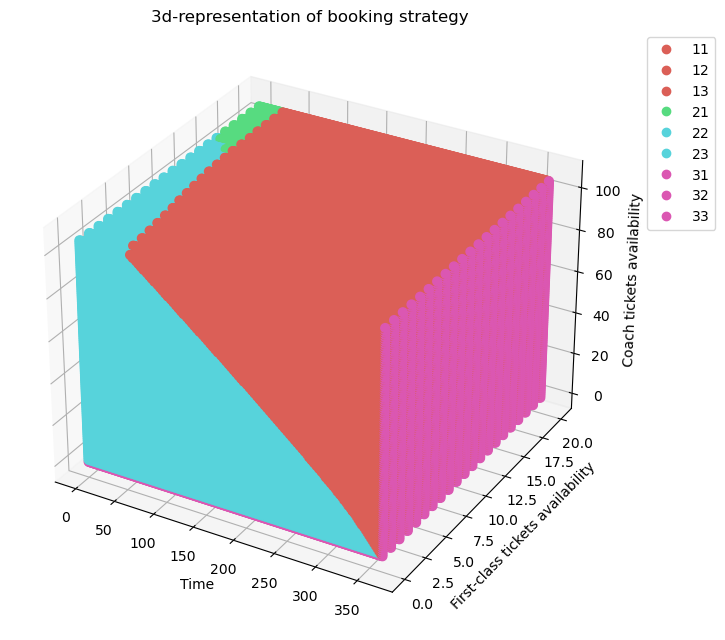

In [7]:
# this code block takes a minute to run. This generates a scatter plot in 3-dimension representing the booking
# strategy
fig = plt.figure(figsize=(6,6))
ax = Axes3D(fig, auto_add_to_figure=False)
fig.add_axes(ax)

# get colormap from seaborn
cmap = ListedColormap(sns.color_palette('hls',8).as_hex())

# plot
sc = ax.scatter(x, y, z, s=40, c=U_5[z,x,y], marker='o', cmap=cmap, alpha=1)
ax.set_xlabel('Time')
ax.set_ylabel('First-class tickets availability')
ax.set_zlabel('Coach tickets availability')

# legend
plt.legend(*sc.legend_elements(), bbox_to_anchor=(1.05, 1), loc=2)

plt.title('3d-representation of booking strategy')
plt.show()

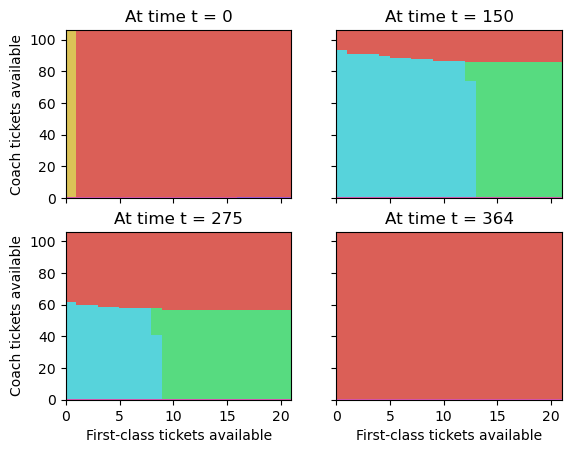

In [8]:
# At a random times
fig, axs = plt.subplots(2, 2)
axs[0, 0].pcolor(U_5[:,0,:] , cmap = cmap);
axs[0, 0].set_title('At time t = 0')
axs[0, 1].pcolor(U_5[:,100,:] , cmap = cmap);
axs[0, 1].set_title('At time t = 150')
axs[1, 0].pcolor(U_5[:,200,:] , cmap = cmap);
axs[1, 0].set_title('At time t = 275')
axs[1, 1].pcolor(U_5[:,364,:] , cmap = cmap);
axs[1, 1].set_title('At time t = 364')
# plt.legend(*sc.legend_elements(), bbox_to_anchor=(1.05, 1), loc=2)
for ax in axs.flat:
    ax.set(xlabel='First-class tickets available', ylabel='Coach tickets available')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()
plt.show()

### Booking Strategy
- 11: Both the tickets are priced low
- 12: Coach is priced low and first-class is priced high
- 13: Coach is priced low and first-class is unavailable
- 21: Coach is priced high and first-class is priced low
- 22: Both the tickets are priced high
- 23: Coach is priced high and first-class is unavailable
- 31: Coach is unavailable and first-class is priced low
- 32: Coach is unavailable and first-class is priced high
- 33: Both the tickets are unavailable

## Estimating expected profits for overbooking 5-15 coach tickets

In [9]:
# this code block takes time
extra_l_5inc = [i for i in range(5,16)]
ex_profit = {}
for e in extra_l_5inc:
    extra = {'coach':e,'first-class':0}
    U,V = tickets_price_optimizer(M,extra,costs,price,prob,delta,T)
    ex_profit[e] = V[M['coach']+extra['coach'],0,M['first-class']+extra['first-class']]

In [10]:
ex_profit

{5: 41886.15862419589,
 6: 42011.221060444535,
 7: 42085.536155828784,
 8: 42122.16726876307,
 9: 42134.62483034169,
 10: 42132.900382351145,
 11: 42123.66593558076,
 12: 42111.029670478645,
 13: 42097.41950987738,
 14: 42084.11157035309,
 15: 42071.74230930798}

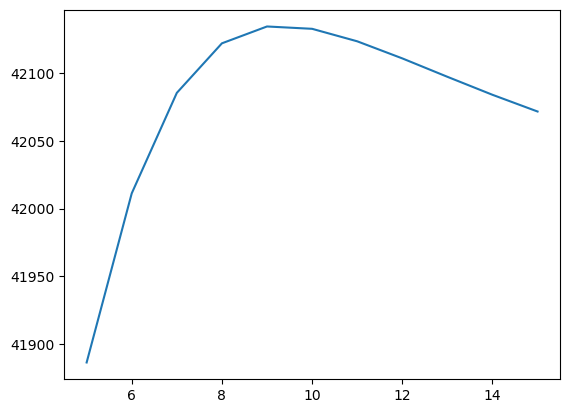

In [11]:
plt.plot(ex_profit.keys(),ex_profit.values())

## Adding the choice of not selling coach tickets despite having them available

In [12]:
# modified function to incorporate the choice of not selling coach tickets despite having them available.

def mod_tickets_price_optimizer(M,extra,costs,price,prob,delta,T):
    
    scValues = np.arange(M['coach']+extra['coach']+1) # all possible number of seats left in coach
    sfValues = np.arange(M['first-class']+extra['first-class']+1) # all possible number of seats left in first-class
    tValues = np.arange(T+1) # all possible days until takeoff
    scN = len(scValues)# count possible state values
    sfN = len(sfValues)# count possible state values
    tN = len(tValues)
    V = np.zeros((scN,tN,sfN)) # initialize value function
    U = np.zeros((scN,tN,sfN)) # initialize optimal choice variable
    
    pricecL = price['coach'][0] # lower choice of price of a coach ticket
    pricecH = price['coach'][1]  # higher choice of price of a coach ticket
    pricefL = price['first-class'][0] # lower choice of price of a first-class ticket
    pricefH = price['first-class'][1] # higher choice of price of a first-class ticket

    pcL = [1-prob['coach'][0],prob['coach'][0]] # demand probabilities for low price coach ticket
    pcH = [1-prob['coach'][1],prob['coach'][1]] # demand probabilities for high price coach ticket
    pfL = [1-prob['first-class'][0],prob['first-class'][0]] # demand probabilities for low price first-class ticket
    pfH = [1-prob['first-class'][1],prob['first-class'][1]] # demand probabilities for high price first-class ticket
    Mc = M['coach'] # number of seats in coach
    Mf = M['first-class'] # number of seats in first-class

    #boundary/terminal condition
    U[:,tN-1,:] = 33 # 3 is the value for no tickets for sale. Ten's digit represents the optimal decision 
    # for coach tickets and the units digit represents the optimal decision for first-class tickets. 1: lower price
    # 2: higher price
    
    # cost calculation for each of the scenarios of number of seats still available in coach and first-class at the
    # time of takeoff.
    for sc in range(scN):
        tc = scN - sc-1 # number of coach tickets booked
        for sf in range(sfN):
            tf = sfN - sf-1 # number of first-class tickets booked
            cost = 0
            for tc_act in range(tc+1):# looping over each possible number of coach passengers actually showing up
                # on the day of departure
                pr_tc_act = scipy.stats.binom.pmf(tc_act,tc,0.95)# probability of 'tc_act' number of 
                # people showing up out of 'tc'
                for tf_act in range(tf+1):# looping over each possible number of first-class passengers actually 
                #showing up on the day of departure
                    pr_tf_act = scipy.stats.binom.pmf(tf_act,tf,0.97)# probability of 'tf_act' number of 
                    # people showing up out of 'tf'
                    if tc_act<=Mc:# if the number of coach passengers who showed up is less than the capacity of
                        # coach then there will be no cost.
                        cost = cost+0
                    else:
                        if tc_act-Mc <= Mf-tf_act:# if the number of coach passengers who showed up is higher than the
                        #capacity of coach but lower than the seats remaining in first-class then the cost would be the
                        # cost associated with bumping all of them to first-class
                            cost = cost - pr_tc_act*pr_tf_act*costs['ctof']*(tc_act-Mc)
                        else:
                        # if the number of coach passengers who showed up is higher than the capacity of coach and 
                        # higher than the seats remaining in first-class then the cost would be the
                        # cost associated with bumping some of them till first-class is filled and bumping the
                        # remaining passengers off the plane.
                            cost = cost - pr_tc_act*pr_tf_act*(costs['ctof']*(Mf-tf_act) 
                                                               + costs['ctoout']*(tc_act-Mc-(Mf-tf_act)))
            V[sc,tN-1,sf] = cost
        
        
    # using Bellman equation to calculate the expected Value backward in time for each of the scenarios    
    for t in reversed(range(tN-1)):
        for sc in range(scN):
            for sf in range(sfN):

                if sc==0 and sf==0: # is the flight full (0 seats left)
                    V[sc,t,sf]=delta*V[sc,t+1,sf] # if so, you can't make any more money
                    U[sc,t,sf]=33 # (coach,first-class)

                elif sc !=0 and sf==0:# there are coach tickets available but not first-class. This increases the 
                    # probability of sale coach tickets by 0.03.
                    # value if you set the coach ticket price low
                    valueLc = (pcL[1]+0.03)*pricecL + delta* ((pcL[0]-0.03)*V[sc,t+1,sf] + (pcL[1]+0.03)*V[sc-1,t+1,sf])
                    # value if you set the coach ticket price high
                    valueHc = (pcH[1]+0.03)*pricecH + delta* ((pcH[0]-0.03)*V[sc,t+1,sf] + (pcH[1]+0.03)*V[sc-1,t+1,sf]) 
                    # value if you decide not to sell the coach ticket
                    value0c = 0 + delta*V[sc,t+1,sf] 

                    V[sc,t,sf]=max(valueLc,valueHc,value0c) # value function maximizes expected profit
                    U[sc,t,sf]=(np.argmax([valueLc,valueHc,value0c])+1)*10+3

                elif sc == 0 and sf!=0:# there are first-class tickets available but not coach
                    # value if you set the first-class ticket price low
                    valueLf = (pfL[1])*pricefL + delta* ((pfL[0])*V[sc,t+1,sf] + (pfL[1])*V[sc,t+1,sf-1])
                    # value if you set the first-class ticket price high
                    valueHf = (pfH[1])*pricefH + delta* ((pfH[0])*V[sc,t+1,sf] + (pfH[1])*V[sc,t+1,sf-1])


                    V[sc,t,sf]=max(valueLf,valueHf) # value function maximizes expected revenue
                    U[sc,t,sf]=30+np.argmax([valueLf,valueHf])+1

                else:
                    # value if you decide not to sell coach and set first-class ticket price low
                    value0L = pfL[1]*pricefL + delta* (pfL[0]*V[sc,t+1,sf]+pfL[1]*V[sc,t+1,sf-1])

                    # value if you decide not to sell coach and set first-class ticket price high
                    value0H = pfH[1]*pricefH + delta* (pfH[0]*V[sc,t+1,sf]+pfH[1]*V[sc,t+1,sf-1])

                    # value if you set both coach and first-class ticket prices low
                    valueLL = pcL[1]*pricecL + pfL[1]*pricefL + delta* (pfL[0]*pcL[0]*V[sc,t+1,sf]
                                                                        +pfL[0]*pcL[1]*V[sc-1,t+1,sf]
                                                                        +pfL[1]*pcL[1]*V[sc-1,t+1,sf-1]
                                                                        +pfL[1]*pcL[0]*V[sc,t+1,sf-1])
                    
                    # value if you set coach ticket price low and first-class ticket price high
                    valueLH = pcL[1]*pricecL + pfH[1]*pricefH + delta* (pfH[0]*pcL[0]*V[sc,t+1,sf]
                                                                        +pfH[0]*pcL[1]*V[sc-1,t+1,sf]
                                                                        +pfH[1]*pcL[1]*V[sc-1,t+1,sf-1]
                                                                        +pfH[1]*pcL[0]*V[sc,t+1,sf-1])

                    # value if you set coach ticket price high and first-class ticket price low
                    valueHL = pcH[1]*pricecH + pfL[1]*pricefL + delta* (pfL[0]*pcH[0]*V[sc,t+1,sf]
                                                                        +pfL[0]*pcH[1]*V[sc-1,t+1,sf]
                                                                        +pfL[1]*pcH[1]*V[sc-1,t+1,sf-1]
                                                                        +pfL[1]*pcH[0]*V[sc,t+1,sf-1])
                    
                    # value if you set both coach and first-class ticket prices high
                    valueHH = pcH[1]*pricecH + pfH[1]*pricefH + delta* (pfH[0]*pcH[0]*V[sc,t+1,sf]
                                                                        +pfH[0]*pcH[1]*V[sc-1,t+1,sf]
                                                                        +pfH[1]*pcH[1]*V[sc-1,t+1,sf-1]
                                                                        +pfH[1]*pcH[0]*V[sc,t+1,sf-1])


                    V[sc,t,sf]=max(valueLL,valueLH,valueHL,valueHH,value0L,value0H) # value funciton maximizes expected profit 

                    U[sc,t,sf]=(int(np.argmax([valueLL,valueLH,valueHL,valueHH,value0L,value0H])/2)+1)*10\
                    +int((np.argmax([valueLL,valueLH,valueHL,valueHH,value0L,value0H])%2)!=0)+1
    return U,V

In [13]:
extra_mod = {'coach':20,'first-class':0}
U_mod,V_mod = mod_tickets_price_optimizer(M,extra_mod,costs,price,prob,delta,T)

In [14]:
V_mod[120,0,20]

42139.892762319796

## Estimating expected profits for overbooking 5-20 coach tickets

In [15]:
# this code block takes time
extra_l_mod = [i for i in range(5,21)]
ex_profit_mod = {}
for e in extra_l_mod:
    extra_mod = {'coach':e,'first-class':0}
    U_mod,V_mod = mod_tickets_price_optimizer(M,extra_mod,costs,price,prob,delta,T)
    ex_profit_mod[e] = V_mod[M['coach']+extra_mod['coach'],0,M['first-class']+extra_mod['first-class']]

In [16]:
ex_profit_mod

{5: 41886.15862419589,
 6: 42011.221060444535,
 7: 42085.536155828784,
 8: 42122.16726876307,
 9: 42134.62483034169,
 10: 42138.14049791316,
 11: 42139.32793981836,
 12: 42139.70894506632,
 13: 42139.83142494603,
 14: 42139.87222493402,
 15: 42139.886081064586,
 16: 42139.89071111936,
 17: 42139.89218324263,
 18: 42139.892617266545,
 19: 42139.892734024594,
 20: 42139.892762319796}

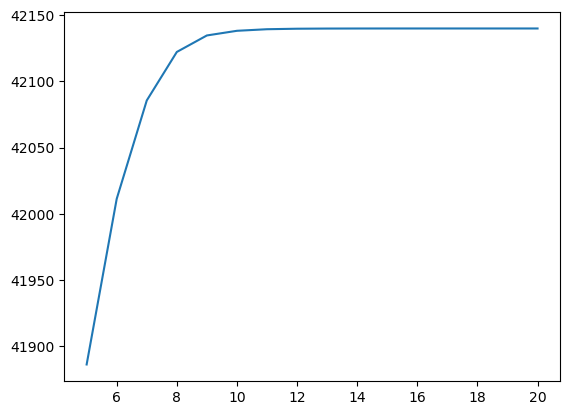

In [17]:
plt.plot(ex_profit_mod.keys(),ex_profit_mod.values())

## Optimal overbooking strategy without the option of not selling coach tickets despite them being available

In [18]:
extra = {'coach':9,'first-class':0}
U_opt,V_opt = tickets_price_optimizer(M,extra,costs,price,prob,delta,T)

In [19]:
V_opt[109,0,20]

42134.62483034169

## Simulating to analyze the overbooking strategies

In [20]:
# This is a function which takes in the extra seats we have decided to overbook and the corresponding
# decision matrix, and gives out expected profit, number of coach and first-class tickets booked, and the actual
# number of coach and first-class passengers who show during departure
def profit_sim(U,V,extra):
    sc = 100 + extra # on the first day all seats (capacity+extra) are available in coach
    sf = 20 # on the first day all seats are available in first-class
    tN = 366 # 0-365 is 366 values
    total_rev_c = 0 # we haven't made any money from coach ticket sales yet
    total_rev_f = 0 # we haven't made any money from first-class ticket sales yet
    seatsc_left_vec = np.zeros(tN-1) # store how many seats left in coach(capacity+extra) after each time t
    seatsf_left_vec = np.zeros(tN-1) # store how many seats left in first-class after each time t
    revenuec_vec = np.zeros(tN-1) # discounted revenue generated adter each time t from coach sales
    revenuef_vec = np.zeros(tN-1) # discounted revenue generated adter each time t from first-class sales
    pricec_vec = np.zeros(tN-1) # price decided for coach sales at each time t
    pricef_vec = np.zeros(tN-1) # price decided for first-class sales at each time t
    for t in range(tN-1): # loop forward in time...don't need last time period since we can't sell anything then
        opt_price_c = int(U[sc,t,sf]/10) # how much should we charge for coach ticket
        opt_price_f = int(U[sc,t,sf]%10) # how much should we charge for first-class ticket
        pricec_vec[t] = opt_price_c
        pricef_vec[t] = opt_price_f

        if opt_price_c != 3 and opt_price_f != 3: # if both coach and first-class tickets are being sold

            actual_price_c = price['coach'][opt_price_c-1]
            actual_price_f = price['first-class'][opt_price_f-1]
            prob_sale_c = prob['coach'][opt_price_c-1]
            prob_sale_f = prob['first-class'][opt_price_f-1]

        elif opt_price_c == 3 and opt_price_f != 3: # if only first-class tickets are being sold
            actual_price_c = 0
            actual_price_f = price['first-class'][opt_price_f-1]
            prob_sale_c = 0
            prob_sale_f = prob['first-class'][opt_price_f-1]

        elif opt_price_c != 3 and opt_price_f == 3: # if only coach tickets are being sold
            actual_price_c = price['coach'][opt_price_c-1]
            actual_price_f = 0
            prob_sale_c = prob['coach'][opt_price_c-1]+0.03
            prob_sale_f = 0

        else: # no tickets for sale
            actual_price_c = 0
            actual_price_f = 0
            prob_sale_c = 0
            prob_sale_f = 0

        sale_c = (np.random.random(1)<prob_sale_c) # simulate whether a coach sale was made or not
        sale_f = (np.random.random(1)<prob_sale_f) # simulate whether a first-class sale was made or not
        # when the flight is full the probability of sale is 0, we'll never get a sale
        sc = int(sc - sale_c) # subtract whether or not a sale was made in coach
        sf = int(sf - sale_f) # subtract whether or not a sale was made in first-class
        total_rev_c = total_rev_c + int(sale_c)*actual_price_c*(delta**(t)) # add discounted revenue generated from
        # coach sales
        total_rev_f = total_rev_f + int(sale_f)*actual_price_f*(delta**(t)) # add discounted revenue generated from
        # first-class sales
        # save the results
        seatsc_left_vec[t] = sc
        seatsf_left_vec[t] = sf
        revenuec_vec[t] = total_rev_c
        revenuef_vec[t] = total_rev_f

    total_rev = total_rev_c+total_rev_f # total revenue generated
    tc = 100+extra-sc # total number of coach tickets sold
    tf = 20-sf # total number of first-class tickets sold
    tc_act = (np.random.choice([1,0],tc,p=[0.95,0.05])).sum() # actual number of coach passengers who showed up
    #during departure
    tf_act = (np.random.choice([1,0],tf,p=[0.97,0.03])).sum() # actual number of first-class passengers who showed up
    #during departure
    if tc_act < 100: # if the number of coach passengers who actually show up during departure is less than the
        # capacity of coach
        cost = 0
    elif tc_act-100 < 20-tf_act: # if the number of coach passengers who actually show up during departure is more
        # than the capacity of coach but less than the vacancies in first-class
        cost = costs['ctof']*(tc_act-100)
    else: # if the number of coach passengers who actually show up during departure is more
        # than the capacity of coach and the vacancies in first-class
        cost = costs['ctof']*(20-tf_act)+costs['ctoout']*((tc_act-100)-(20-tf_act))
    
    profit = total_rev - (delta**(tN-1))*cost
    ctoout_count = max(0,(tc_act-100)-(20-tf_act))
    
    return tc,tf,tc_act,tf_act,profit,ctoout_count,cost


### Examining the policy of overbooking 9 coach tickets with no option to skip selling them

In [21]:
nsim = 5000
profits_list = []
tc_act_list = []
tf_act_list = []
tc_list = []
tf_list = []
ctoout_count_list = []
cost_list = []
np.random.seed(10)
for sim in range(nsim):
    tc,tf,tc_act, tf_act,profit,ctoout_count,cost = profit_sim(U_opt,V_opt,9)
    profits_list.append(profit)
    tc_list.append(tc)
    tf_list.append(tf)
    tc_act_list.append(tc_act)
    tf_act_list.append(tf_act)
    ctoout_count_list.append(ctoout_count)
    cost_list.append(cost)

print('Average discounted profit when we decide to have 9 coach tickets to be overbooked:',np.array(profits_list).mean())
print('Standard deviation of discounted profit when we decide to have 9 coach tickets to be overbooked:',np.array(profits_list).std())

Average discounted profit when we decide to have 9 coach tickets to be overbooked: 42155.65332159955
Standard deviation of discounted profit when we decide to have 9 coach tickets to be overbooked: 930.9011193456435


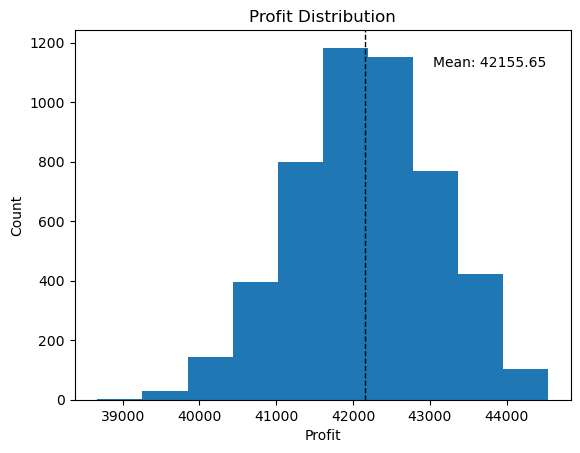

In [22]:
plt.hist(profits_list)
plt.axvline(np.array(profits_list).mean(), color='k', linestyle='dashed', linewidth=1)
min_ylim, max_ylim = plt.ylim()
min_xlim, max_xlim = plt.xlim()
plt.text(max_xlim*0.96, max_ylim*0.9, 'Mean: {:.2f}'.format(np.array(profits_list).mean()))
plt.title('Profit Distribution')
plt.xlabel('Profit')
plt.ylabel('Count')
plt.show()

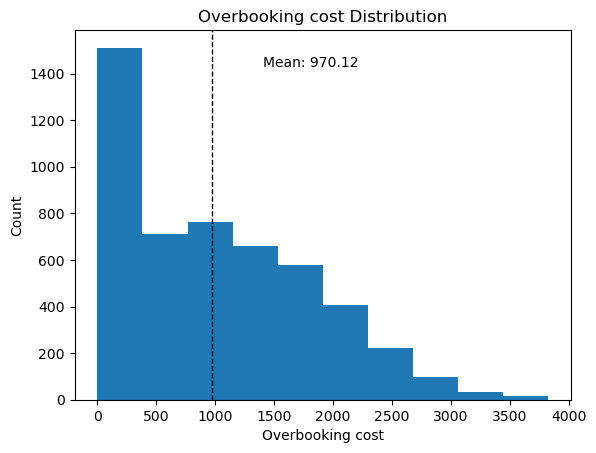

In [23]:
plt.hist(cost_list)
plt.axvline(np.array(cost_list).mean(), color='k', linestyle='dashed', linewidth=1)
min_ylim, max_ylim = plt.ylim()
min_xlim, max_xlim = plt.xlim()
plt.text(max_xlim*0.35, max_ylim*0.9, 'Mean: {:.2f}'.format(np.array(cost_list).mean()))
plt.title('Overbooking cost Distribution')
plt.xlabel('Overbooking cost')
plt.ylabel('Count')
plt.show()

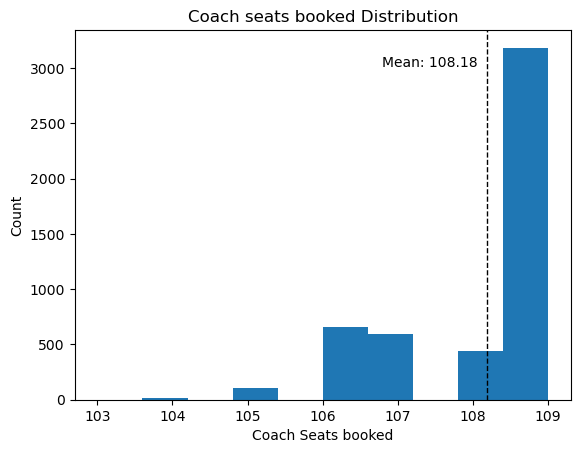

In [24]:
plt.hist(tc_list)
plt.axvline(np.array(tc_list).mean(), color='k', linestyle='dashed', linewidth=1)
min_ylim, max_ylim = plt.ylim()
min_xlim, max_xlim = plt.xlim()
plt.text(max_xlim*0.977, max_ylim*0.9, 'Mean: {:.2f}'.format(np.array(tc_list).mean()))
plt.title('Coach seats booked Distribution')
plt.xlabel('Coach Seats booked')
plt.ylabel('Count')
plt.show()

The coach is always overbooked if we have the option.

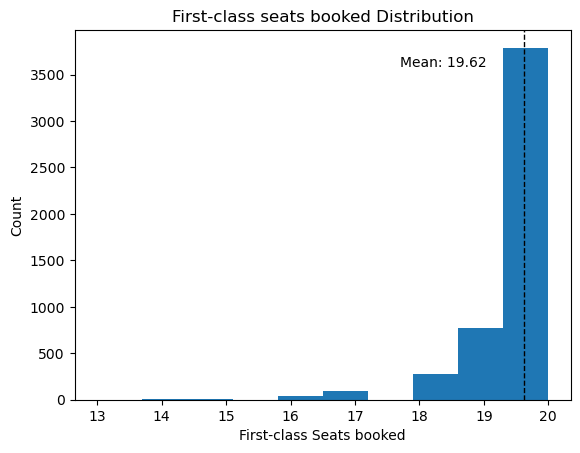

In [25]:
plt.hist(tf_list)
plt.axvline(np.array(tf_list).mean(), color='k', linestyle='dashed', linewidth=1)
min_ylim, max_ylim = plt.ylim()
min_xlim, max_xlim = plt.xlim()
plt.text(max_xlim*0.87, max_ylim*0.9, 'Mean: {:.2f}'.format(np.array(tf_list).mean()))
plt.title('First-class seats booked Distribution')
plt.xlabel('First-class Seats booked')
plt.ylabel('Count')
plt.show()

Even if it looks like the probability of selling a first-class ticket is low, it mostly gets fully booked due to the higher number of days to book them than the number of first-class tickets.

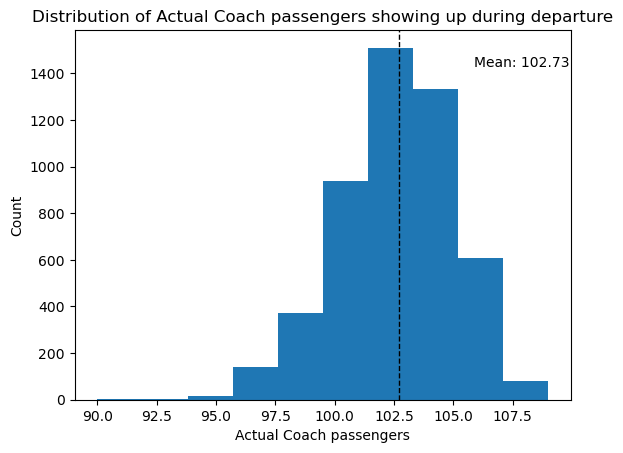

In [26]:
plt.hist(tc_act_list)
plt.axvline(np.array(tc_act_list).mean(), color='k', linestyle='dashed', linewidth=1)
min_ylim, max_ylim = plt.ylim()
min_xlim, max_xlim = plt.xlim()
plt.text(max_xlim*0.963, max_ylim*0.9, 'Mean: {:.2f}'.format(np.array(tc_act_list).mean()))
plt.title('Distribution of Actual Coach passengers showing up during departure')
plt.xlabel('Actual Coach passengers')
plt.ylabel('Count')
plt.show()

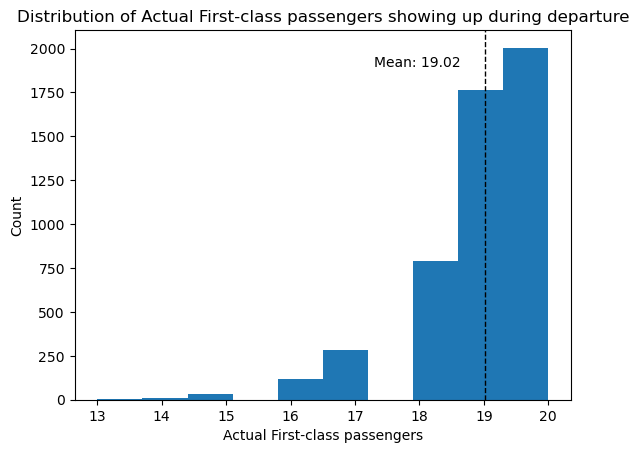

In [27]:
plt.hist(tf_act_list)
plt.axvline(np.array(tf_act_list).mean(), color='k', linestyle='dashed', linewidth=1)
min_ylim, max_ylim = plt.ylim()
min_xlim, max_xlim = plt.xlim()
plt.text(max_xlim*0.85, max_ylim*0.9, 'Mean: {:.2f}'.format(np.array(tf_act_list).mean()))
plt.title('Distribution of Actual First-class passengers showing up during departure')
plt.xlabel('Actual First-class passengers')
plt.ylabel('Count')
plt.show()

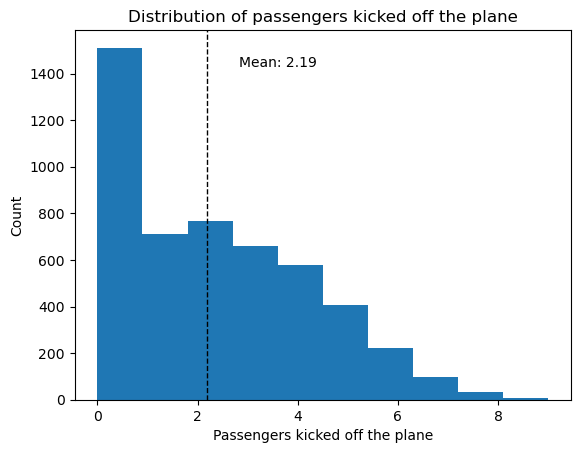

In [28]:
plt.hist(ctoout_count_list)
plt.axvline(np.array(ctoout_count_list).mean(), color='k', linestyle='dashed', linewidth=1)
min_ylim, max_ylim = plt.ylim()
min_xlim, max_xlim = plt.xlim()
plt.text(max_xlim*0.30, max_ylim*0.9, 'Mean: {:.2f}'.format(np.array(ctoout_count_list).mean()))
plt.title('Distribution of passengers kicked off the plane')
plt.xlabel('Passengers kicked off the plane')
plt.ylabel('Count')
plt.show()

In [29]:
print('The number of times no passenger gets kicked off the plane is '+str(ctoout_count_list.count(0))+' out of 5000. '+
'Even though the number of times no passenger gets kicked off the plane is high, the number of times atleast 1 passenger'+
' gets kicked off the plane is higher i.e., '+str(5000-ctoout_count_list.count(0)))

The number of times no passenger gets kicked off the plane is 1511 out of 5000. Even though the number of times no passenger gets kicked off the plane is high, the number of times atleast 1 passenger gets kicked off the plane is higher i.e., 3489


### Examining the policy of overbooking 20 coach tickets with the option to skip selling them if it more profitable

In [30]:
extra_mod = {'coach':20,'first-class':0}
U_mod_opt,V_mod_opt = mod_tickets_price_optimizer(M,extra_mod,costs,price,prob,delta,T)

In [31]:
profits_list_mod = []
tc_list_mod = []
tf_list_mod = []
tc_act_list_mod = []
tf_act_list_mod = []
ctoout_count_list_mod = []
cost_list_mod = []
np.random.seed(10)
for sim in range(nsim):
    tc,tf,tc_act, tf_act,profit,ctoout_count,cost = profit_sim(U_mod_opt,V_mod_opt,20)
    profits_list_mod.append(profit)
    tc_list_mod.append(tc)
    tf_list_mod.append(tf)
    tc_act_list_mod.append(tc_act)
    tf_act_list_mod.append(tf_act)
    ctoout_count_list_mod.append(ctoout_count)
    cost_list_mod.append(cost)

print('Average discounted profit when we decide to have 20 coach tickets to be overbooked with the option of not selling:',np.array(profits_list_mod).mean())
print('Standard deviation of discounted profit when we decide to have 9 coach tickets to be overbooked:',np.array(profits_list_mod).std())

Average discounted profit when we decide to have 20 coach tickets to be overbooked with the option of not selling: 42149.15634057132
Standard deviation of discounted profit when we decide to have 9 coach tickets to be overbooked: 929.308313925256


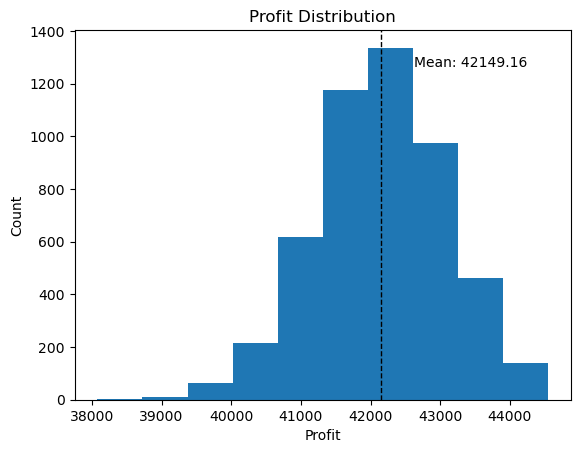

In [32]:
plt.hist(profits_list_mod)
plt.axvline(np.array(profits_list_mod).mean(), color='k', linestyle='dashed', linewidth=1)
min_ylim, max_ylim = plt.ylim()
min_xlim, max_xlim = plt.xlim()
plt.text(max_xlim*0.95, max_ylim*0.9, 'Mean: {:.2f}'.format(np.array(profits_list_mod).mean()))
plt.title('Profit Distribution')
plt.xlabel('Profit')
plt.ylabel('Count')
plt.show()

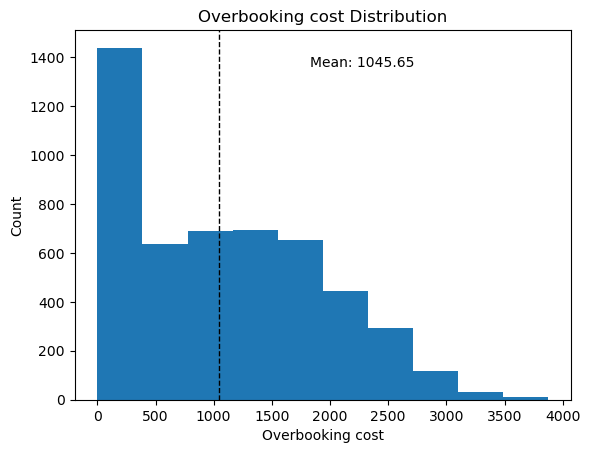

In [33]:
plt.hist(cost_list_mod)
plt.axvline(np.array(cost_list_mod).mean(), color='k', linestyle='dashed', linewidth=1)
min_ylim, max_ylim = plt.ylim()
min_xlim, max_xlim = plt.xlim()
plt.text(max_xlim*0.45, max_ylim*0.9, 'Mean: {:.2f}'.format(np.array(cost_list_mod).mean()))
plt.title('Overbooking cost Distribution')
plt.xlabel('Overbooking cost')
plt.ylabel('Count')
plt.show()

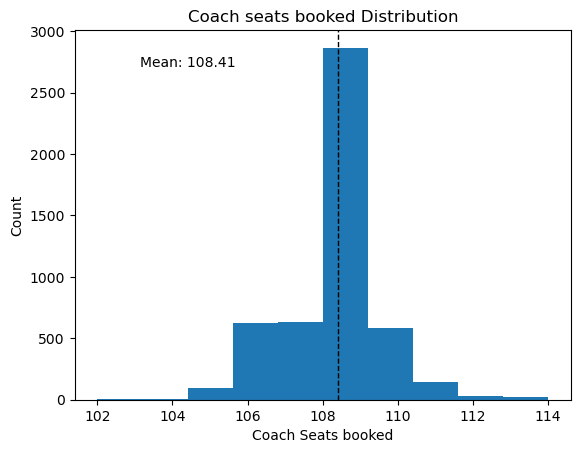

In [34]:
plt.hist(tc_list_mod)
plt.axvline(np.array(tc_list_mod).mean(), color='k', linestyle='dashed', linewidth=1)
min_ylim, max_ylim = plt.ylim()
min_xlim, max_xlim = plt.xlim()
plt.text(max_xlim*0.90, max_ylim*0.9, 'Mean: {:.2f}'.format(np.array(tc_list_mod).mean()))
plt.title('Coach seats booked Distribution')
plt.xlabel('Coach Seats booked')
plt.ylabel('Count')
plt.show()

The number of coach seats booked is rarely higher than 109 as that is point where we get the highest expected profit.

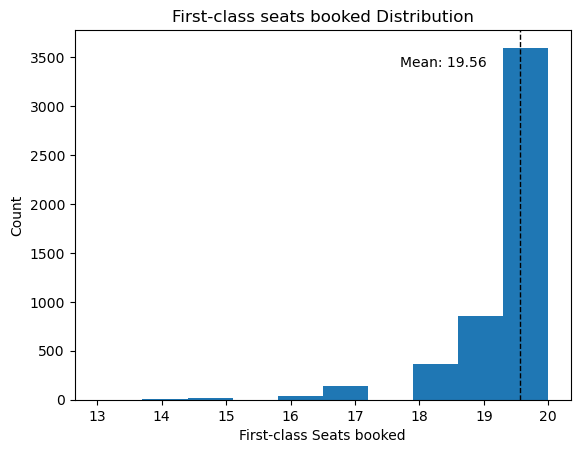

In [35]:
plt.hist(tf_list_mod)
plt.axvline(np.array(tf_list_mod).mean(), color='k', linestyle='dashed', linewidth=1)
min_ylim, max_ylim = plt.ylim()
min_xlim, max_xlim = plt.xlim()
plt.text(max_xlim*0.87, max_ylim*0.9, 'Mean: {:.2f}'.format(np.array(tf_list_mod).mean()))
plt.title('First-class seats booked Distribution')
plt.xlabel('First-class Seats booked')
plt.ylabel('Count')
plt.show()

As already seen above, first-class mostly gets fully booked due to the higher number of days to book them than the number of first-class tickets.

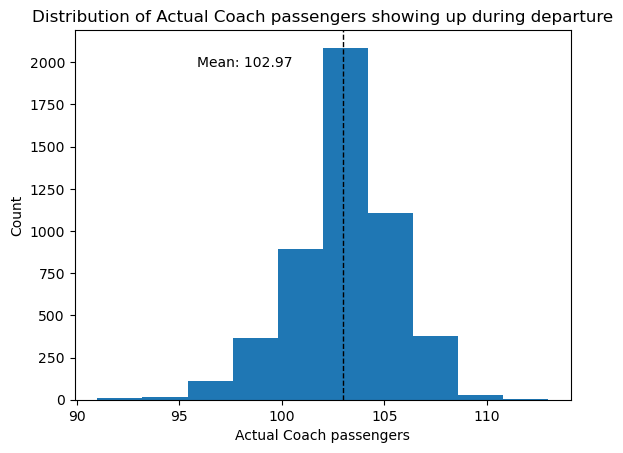

In [36]:
plt.hist(tc_act_list_mod)
plt.axvline(np.array(tc_act_list_mod).mean(), color='k', linestyle='dashed', linewidth=1)
min_ylim, max_ylim = plt.ylim()
min_xlim, max_xlim = plt.xlim()
plt.text(max_xlim*0.84, max_ylim*0.9, 'Mean: {:.2f}'.format(np.array(tc_act_list_mod).mean()))
plt.title('Distribution of Actual Coach passengers showing up during departure')
plt.xlabel('Actual Coach passengers')
plt.ylabel('Count')
plt.show()

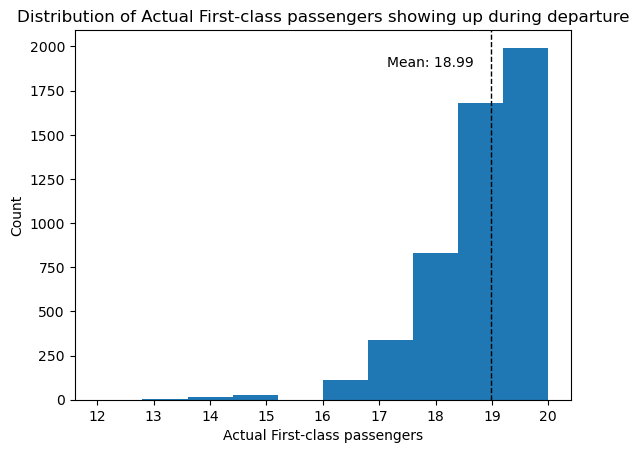

In [37]:
plt.hist(tf_act_list_mod)
plt.axvline(np.array(tf_act_list_mod).mean(), color='k', linestyle='dashed', linewidth=1)
min_ylim, max_ylim = plt.ylim()
min_xlim, max_xlim = plt.xlim()
plt.text(max_xlim*0.84, max_ylim*0.9, 'Mean: {:.2f}'.format(np.array(tf_act_list_mod).mean()))
plt.title('Distribution of Actual First-class passengers showing up during departure')
plt.xlabel('Actual First-class passengers')
plt.ylabel('Count')
plt.show()

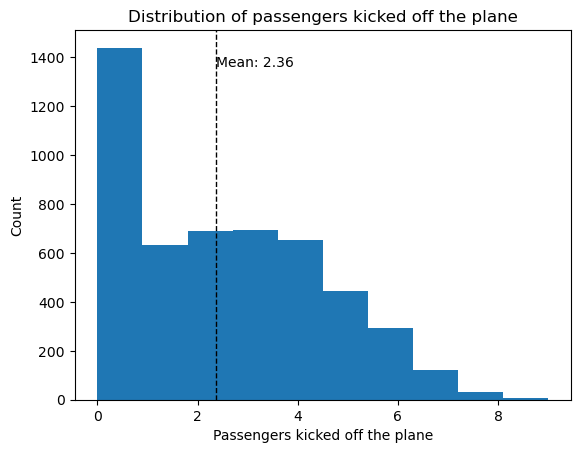

In [38]:
plt.hist(ctoout_count_list_mod)
plt.axvline(np.array(ctoout_count_list_mod).mean(), color='k', linestyle='dashed', linewidth=1)
min_ylim, max_ylim = plt.ylim()
min_xlim, max_xlim = plt.xlim()
plt.text(max_xlim*0.25, max_ylim*0.9, 'Mean: {:.2f}'.format(np.array(ctoout_count_list_mod).mean()))
plt.title('Distribution of passengers kicked off the plane')
plt.xlabel('Passengers kicked off the plane')
plt.ylabel('Count')
plt.show()

In [39]:
print('The number of times no passenger gets kicked off the plane is '+str(ctoout_count_list_mod.count(0))+' out of 5000. '+
'Even though the number of times no passenger gets kicked off the plane is high, the number of times atleast 1 passenger'+
' gets kicked off the plane is higher i.e., '+str(5000-ctoout_count_list_mod.count(0)))

The number of times no passenger gets kicked off the plane is 1439 out of 5000. Even though the number of times no passenger gets kicked off the plane is high, the number of times atleast 1 passenger gets kicked off the plane is higher i.e., 3561
